Introduction to Pre-Training and Transfer Learning for with RNNs

In previous lessons, we built and trained RNNs from scratch. However in practice, this is not necessary or even encouraged, especially if you want to reduce time and cost, or have few labeled data points.

In this module, we will learn about transfer learning in NLP. In convolutional neural nets, backbones are generally trained using one task, then fine-tuned on another task. The same is generally true with transfer learning in NLP, except that language models are generally used to do pre-training, instead of classification on ImageNet.

As humans, we have an incredible capability. We know tens of thousands of words in our head, sometimes in many different tenses, conjugations, etc. Given the sentence below, my guess is that you will easily be able to complete the sentence with a word that make sense given the context.

It snowed on the slopes today, it was a great day for ...

You probably easily filled that word with something like skiing, snowboarding, sledding, etc. In language modeling, this what we're trying to teach the model how to do. We use an unsupervised approach to learning a language dataset by trying to predict the next word in a sequence. Given a sequence of words, \(w_1, w_2 ... w_n\), we try to correctly classify \(w_{n+1}\).

Today, we fine-tune a pre-trained language model from fastai, then use it to classify movie reviews by sentiment. We will be following the general procedure outlined by Universal Language Model Fine-tuning for Text Classification (ULMFiT). A more detailed walkthrough of this procedure can be found in this chapter of the FastAI book chapter about transfer learning with RNNs. In FastAI, tokenization and numericalization are built in. Please see the book chapter linked for specifics on how it all works.

The figure below is from the ULMFiT paper. This represents the training steps that they used to improve performance on text classification tasks using pre-training.

First, the authors trained a language model (AWD LSTM, the same one we'll use in this lesson, panel (a)). This model takes in a sequence of words as inputs and tries to predict the same sequence just shifted by one word (text generation). The input layer is an embedding, and the final layer is a linear classifier that predicts a probability distribution over the vocabulary for many times.

Second, then fine-tuned that same language model on domain-specific datasets like IMDB (what we'll use today), and AG News (b).

Finally, they removed the language model head and added an untrained classifier head (C). They trained the head only for a few epochs, then trained the entire model together. The authors found that this method significantly improved performance over untrained models.

This technique is extremely useful because in NLP, unlabeled data is plentiful and cheap, but labeled data is scarce and expensive. This give us a ton of power to create classifiers for domain-specific datasets without having a ton of labeled examples.

We will be replicating part of this work in today's lesson. We will load a language model that's already been trained on wikitext103 (We could train it ourselves, but this would take for ever). Then, we'll fine-tune the language model on movie reviews, including many that are unlabeled. Finally, we'll use just the labeled data to train a classifier.

In [1]:
!pip install -Uqq fastai

In [2]:
from fastai import *
from fastai.text.all import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

Dataloaders for Language Modeling

In this lesson, we'll be using the IMDB dataset provided by fastai. This data has three folders with data we'll use to train the language model: train, test, and unsup. The train and test folders contain movie reviews organized into pos and neg folders, which serve as our labels. The unsup folder contains raw texts with no labels. This often mirrors the real world, where you have tons of data without labels but just a small amount of data with labels. This technique allows you to use all the data to learn from, even if you only have labels for part of it.

In [3]:
# Download the data
path = untar_data(URLs.IMDB)
list(path.ls())

[Path('/root/.fastai/data/imdb/tmp_clas'),
 Path('/root/.fastai/data/imdb/train'),
 Path('/root/.fastai/data/imdb/test'),
 Path('/root/.fastai/data/imdb/imdb.vocab'),
 Path('/root/.fastai/data/imdb/tmp_lm'),
 Path('/root/.fastai/data/imdb/unsup'),
 Path('/root/.fastai/data/imdb/README')]

Let's take a look at a description of the dataset, from the README:

Overview

This dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification. This document outlines how the dataset was gathered, and how to use the files provided.

Dataset

The core dataset contains 50,000 reviews split evenly into 25k train and 25k test sets. The overall distribution of labels is balanced (25k pos and 25k neg). We also include an additional 50,000 unlabeled documents for unsupervised learning.

In the entire collection, no more than 30 reviews are allowed for any given movie because reviews for the same movie tend to have correlated ratings. Further, the train and test sets contain a disjoint set of movies, so no significant performance is obtained by memorizing movie-unique terms and their associated with observed labels. In the labeled train/test sets, a negative review has a score <= 4 out of 10, and a positive review has a score >= 7 out of 10. Thus reviews with more neutral ratings are not included in the train/test sets. In the unsupervised set, reviews of any rating are included and there are an even number of reviews > 5 and <= 5.

In our first task of the day, we want to use unlabeled movie reviews and learn from them in a self-supervised way. We will use the train and unsup directories to fine-tune our language model, and the test directory to validate performance.

In this case, we'll set up our task to predict the next word. This means that our targets will just be our inputs, shifted by one position. For example, let's consider the text: "The quick brown fox jumped over the lazy dog." Let's consider a sequence length of 3, and mock our inputs and outputs in a manner that would set a model up to predict the next word.

Inputs	Target
The quick brown	quick brown fox
quick brown fox	brown fox jumped
brown fox jumped	fox jumped over
fox jumped over	over the lazy
over the lazy	the lazy dog
When we set up a task this way, this allows our model to learn about the data in the absence of labels! We'll come back to this concept in the next lesson as well, with a more math-y description.

Let's create our dataloaders object and take a look at a batch. It has two columns - the column on the left is some text from movie reviews, and the right column of is that same text, just shifted by one word. Later on, using RNNs, we will attempt to generate the sequence on the right using the sequence on the left.

NOTE: In previous lectures, we created our own vocab and tokenizers. These are built in with TextDataLoaders. When we call dls.one_batch(), we see that we get word indices. If you want to examine the vocab and tokenizer, the dls object will have a .vocab and a .tokenizer method you can explore.

In [4]:
get_imdb = partial(get_text_files, folders=['train', 'unsup'])

lm_dls = DataBlock(
    blocks=TextBlock.from_folder(path, is_lm=True),
    get_items=get_imdb, splitter=RandomSplitter(0.1)
).dataloaders(path, path=path)

In [5]:
lm_dls.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj this movie was one of the first made after the xxup mpaa rating system replaced the xxmaj hayes code , and people could make porn commercially . xxmaj originally , it got an x rating , and they trimmed it down a bit to give it an xxup r. \n\n xxmaj basically , it parodies the xxmaj flash xxmaj gordan serials of the 1930 's , with stop - motion","xxmaj this movie was one of the first made after the xxup mpaa rating system replaced the xxmaj hayes code , and people could make porn commercially . xxmaj originally , it got an x rating , and they trimmed it down a bit to give it an xxup r. \n\n xxmaj basically , it parodies the xxmaj flash xxmaj gordan serials of the 1930 's , with stop - motion animation"
1,"the xxmaj soviet xxmaj union . xxmaj so , xxmaj holly xxmaj hunter protested xxmaj kazan for something that happened 50 years ago . \n\n i think there are many fine actresses that could have played xxmaj hunter 's role and because of her anti - american positions , i think the role should have been given to someone else . xxmaj otherwise , i would have rated the film higher .","xxmaj soviet xxmaj union . xxmaj so , xxmaj holly xxmaj hunter protested xxmaj kazan for something that happened 50 years ago . \n\n i think there are many fine actresses that could have played xxmaj hunter 's role and because of her anti - american positions , i think the role should have been given to someone else . xxmaj otherwise , i would have rated the film higher . \n\n"


As we can see in the block below, the inputs are a block of text, and the outputs we're trying to predict is that text shifted by one token. This is similar to the setup in the previous module where we built RNNs from scratch to predict time series data. The benefit of this setup is that the model can learn about the data in the absence of labels.

Now, let's look at a single batch of numericalized data. We should make sure that y is x shifted by 1.

In [6]:
x, y = lm_dls.one_batch()

In [7]:
x[0]

LMTensorText([    2,     8,    20,    30,    62,   298,   100,     8,  4281,
                519,   135,  1244,    24,  2692,   471,   135,   658,    24,
                 18,   138,   135,    13,   580,    24,   144,    21,  1064,
                 15,  3787,    13,   227,    14,  1134,   158,   104,    13,
                131,   369,    10,     8,   308,  3560,     9,  3104,    15,
                159,    75,    11,    75,    11,    75,    10,     8,   257,
                 21,   254,    42,    99,  1957,    61,    74,    42, 14824,
                 99,   147,    94,    65,    25,  1957,    18,    10,     8],
             device='cuda:0')

In [8]:
y[0]

TensorText([    8,    20,    30,    62,   298,   100,     8,  4281,   519,
              135,  1244,    24,  2692,   471,   135,   658,    24,    18,
              138,   135,    13,   580,    24,   144,    21,  1064,    15,
             3787,    13,   227,    14,  1134,   158,   104,    13,   131,
              369,    10,     8,   308,  3560,     9,  3104,    15,   159,
               75,    11,    75,    11,    75,    10,     8,   257,    21,
              254,    42,    99,  1957,    61,    74,    42, 14824,    99,
              147,    94,    65,    25,  1957,    18,    10,     8,  1373],
           device='cuda:0')

In [9]:
# Check that the same shift occurs for the entire batch
assert (x[:, 1:] == y[:, :-1]).all()

It looks like all our assumptions are true! In this lesson, we learned how data is organized for language modeling. Finally, we created our dataloaders object and examined a batch of data.

Creating a language model

We will use fastai to train a language model. We'll ask the language model to predict the next word to learn this dataset. We're actually starting with a pre-trained model to begin with. When passing pretrained=True to language_model_learner, we load weights for a language model that was trained on the wikitext103 dataset. Then, like the ULMFiT paper, we will fine tune this language model on the IMDB dataset.

In [10]:
lm_learn = language_model_learner(lm_dls, AWD_LSTM, pretrained=True)

In this exercise, we are training a neural network architecture called AWD LSTM. It should be fairly recognizable to you - there's an embedding layer, three LSTM layers, and a linear layer at the end that classifies each word. The special thing about this network is that it has dropout applied in many different places. Let's take a look at the model below.

As mentioned above, the pre-trained model was trained on data from Wikipedia. We should't expect it to complete movie reviews in a way that makes sense. In the cell below, we generate some text beginning with "This movie was terrible," to see how well it works. It is able to generate some text, but it doesn't read like a movie review. We'll try this again once we've fine-tuned the model on some movie reviews.

Let's fine tune our model on IMDB reviews. Since we don't require labels, we can use the large amount of reviews in the unsup directory. This is similar to real-world NLP, where you may have many unlabeled instances but only a few labels. This technique allows you to learn from unlabeled data as well as labeled data!

In [11]:
lm_learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60008, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60008, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0-2): 3 x RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60008, bias=True)
    (output_dp): RNNDropout()
  )
)

In [12]:
# The model is trained on wikitext, so it will be able to
# generate semi-sensible sentences, but they will likely
# have nothing to do with movies.
lm_learn.predict('This movie was terrible, ', n_words=10)

'This movie was terrible , but the only good thing to do was to make'

In [13]:
LR = 1e-3

In [14]:
lm_learn.fit_one_cycle(1, LR)

epoch,train_loss,valid_loss,time
0,4.432985,4.097354,40:55


Now that we've fine-tuned the language model a bit, it can generate text related to movies quite well.

In [15]:
lm_learn.predict('This movie was terrible, ', n_words=10)

'This movie was terrible , fairly early in its career and regarded as one of'

Finally, let's save our model. We will use parts of this model in the next lesson to perform sentiment analysis on labeled movie reviews.

In [16]:
# Save the model
lm_learn.save_encoder('lm_encoder')

Transfer Learning

Let's review what we've done so far. We've taken a language model trained on wikitext103, and fine-tuned that language model on a bunch of unlabeled data (text from movie reviews).

We will take the backbone of the model we learned, remove the language model head, and attach an untrained classifier. Just like we did with image models, we will freeze the parameters of the backbone and train the classifier, then we will unfreeze all the parameters and train the model all together for a number of epochs.

In [17]:
# Create dataloaders for text classification.
# Let's make sure to pass our vocab from our pre-training
# so the word indices are the same.
dls = TextDataLoaders.from_folder(path, train='train', valid='test', text_vocab=lm_dls.vocab)

Let's set up our model for training. First, we add a few callbacks to save the model and stop it if the validation loss plateaus.

In [18]:
dls.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules of the match , both opponents have to go through tables in order to get the win . xxmaj benoit and xxmaj guerrero heated up early on by taking turns hammering first xxmaj spike and then xxmaj bubba xxmaj ray . a xxmaj german xxunk by xxmaj benoit to xxmaj bubba took the wind out of the xxmaj dudley brother . xxmaj spike tried to help his brother , but the referee restrained him while xxmaj benoit and xxmaj guerrero",pos
1,"xxbos xxmaj warning : xxmaj does contain spoilers . \n\n xxmaj open xxmaj your xxmaj eyes \n\n xxmaj if you have not seen this film and plan on doing so , just stop reading here and take my word for it . xxmaj you have to see this film . i have seen it four times so far and i still have n't made up my mind as to what exactly happened in the film . xxmaj that is all i am going to say because if you have not seen this film , then stop reading right now . \n\n xxmaj if you are still reading then i am going to pose some questions to you and maybe if anyone has any answers you can email me and let me know what you think . \n\n i remember my xxmaj grade 11 xxmaj english teacher quite well . xxmaj",pos
2,"xxbos xxrep 3 * xxup spoilers xxrep 3 * xxrep 3 * xxup spoilers xxrep 3 * xxmaj continued … \n\n xxmaj from here on in the whole movie collapses in on itself . xxmaj first we meet a rogue program with the indication we 're gon na get ghosts and vampires and werewolves and the like . xxmaj we get a guy with a retarded accent talking endless garbage , two ' ghosts ' that serve no real purpose and have no character what - so - ever and a bunch of henchmen . xxmaj someone 's told me they 're vampires ( straight out of xxmaj blade 2 ) , but they 're so undefined i did n't realise . \n\n xxmaj the funny accented guy with a ridiculous name suffers the same problem as the xxmaj oracle , only for far longer and far far worse .",neg


In [19]:
cbs = [
    EarlyStoppingCallback(),
    SaveModelCallback()
]

In the cell below, we create our learner object using our dataloaders for the text classification task and the AWD_LSTM architecture.

In [20]:
# Create a learner for text classification.
learn = text_classifier_learner(dls, AWD_LSTM, metrics=[accuracy, error_rate], cbs=cbs)

At this point, our model is the same model that's been pre-trained on wikitext-103, but we want to use the model we fine-tuned on IMDB. We can use the load_encoder method to load the weights we saved. After running this cell, we have an encoder that has been fine-tuned on movie reviews, and an untrained classification head.

In [21]:
# Load our weights from fine-tuning on full IMDB
learn = learn.load_encoder('lm_encoder')

Let's fine tune our model for 10 epochs. This means that we will train the classifier only for 1 epoch, then unfreeze the entire model and train for 10 epochs (unless we meet our early stopping criteria).

In [22]:
learn.fine_tune(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.418362,0.347071,0.850200,0.149800,03:45


Better model found at epoch 0 with valid_loss value: 0.3470709025859833.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.357849,0.295298,0.875560,0.124440,07:56
1,0.326391,0.264898,0.891680,0.108320,07:56
2,0.288138,0.244958,0.900960,0.099040,07:57
3,0.258267,0.236319,0.907680,0.092320,07:57
4,0.239012,0.223134,0.909280,0.090720,07:55
5,0.231084,0.212122,0.916000,0.084000,07:57
6,0.216249,0.213874,0.914720,0.085280,07:56


Better model found at epoch 0 with valid_loss value: 0.29529812932014465.
Better model found at epoch 1 with valid_loss value: 0.26489800214767456.
Better model found at epoch 2 with valid_loss value: 0.24495801329612732.
Better model found at epoch 3 with valid_loss value: 0.2363191545009613.
Better model found at epoch 4 with valid_loss value: 0.22313383221626282.
Better model found at epoch 5 with valid_loss value: 0.21212154626846313.
No improvement since epoch 5: early stopping


Sanity check: If we give it obviously bad or obviously good movie reviews, does this model work?

In [1]:
learn.predict('This movie was horrible!')

NameError: ignored

In [ ]:
learn.predict('This movie was great!')

In [ ]:
learn.save('clf_fine_tuned')

Finally, let's do a bit of model evaluation. Let's take a look at the confusion matrix for the validation dataset. For this, we'll use fastai's ClassificationInterpretation object.

In [2]:
interp = ClassificationInterpretation.from_learner(learn)

NameError: ignored

Once you've instantiated the interpreter object, you can easily analyze your model's performance. From the confusion matrix below, we can see that the false positive rate and false negative rate are relatively similar.

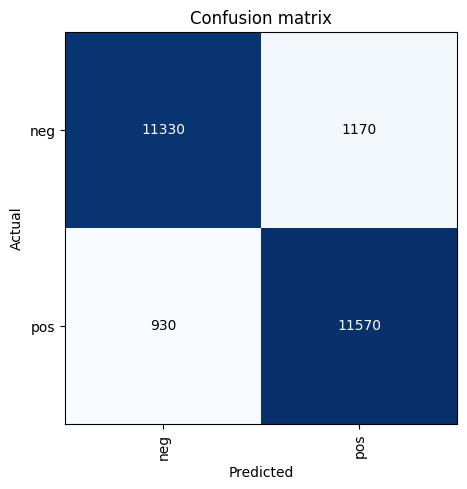

In [27]:
interp.plot_confusion_matrix()

Another useful way to analyze your model qualitatively is to examine the top losses. This is where the inference differs from the label most strongly, and can be useful in identifying samples that might be mis-labeled. Let's take a look at them below. Are any of these labels confusing or possibly wrong?

In [28]:
interp.plot_top_losses(10)

,input,target,predicted,probability,loss
0,"xxbos * * spoilers xxup ahead * * \n\n xxmaj it is really unfortunate that a movie so well produced turns out to be \n\n such a disappointment . i thought this was full of ( silly ) clichés and \n\n that it basically tried to hard . \n\n xxmaj to the ( american ) guys out there : how many of you spend your \n\n time jumping on your girlfriend 's bed and making monkey \n\n sounds ? xxmaj to the ( married ) girls : how many of you have suddenly \n\n gone from prudes to xxunk overnight -- but not with your \n\n husband ? xxmaj to the xxmaj french : would you really ask about someone \n\n being "" à la xxunk "" when you know they do n't speak xxmaj french ? xxmaj would n't \n\n you use a more common word like "" xxunk",pos,neg,0.9996298551559448,11.45113468170166
1,"xxbos xxmaj with the plethora of repetitive and derivative sitcoms jamming fall , summer , winter and spring line - ups , it 's nice to see a show that sets itself from the lot in more than one area . \n\n ' earl ' takes an unusual approach . xxmaj it 's not about the "" daily musings of an eccentric family "" ( xxrep 4 z .. ) nor about the other boring stuff you see everywhere in sitcoms . xxmaj the show is about this small - time white trash thief ( earl ) who scratches off a lottery card and scores big time . xxmaj right at that moment , ' karma ' took it away from him . xxmaj overtime , he learns that that unusual incident was probably because of all the bad things he 's been doing , so he sets off on",neg,pos,0.9996950626373291,10.688621520996094
2,"xxbos i went to see this 3 nights ago here in xxmaj cork , xxmaj ireland . xxmaj it was the world premiere of it , in the tiny cinema in the xxmaj xxunk xxmaj arts xxmaj centre as part of the xxmaj cork xxmaj film xxmaj festival . \n\n i found "" strange xxmaj fruit "" to be an excellent movie . xxmaj it is a bit rough around the edges , but for a low - budget movie that is to be expected ! xxmaj in general the acting ( particularly from the main lead xxmaj kent xxmaj xxunk ) is wonderful , the cinematography and direction excellent , and the script hugely entertaining and thought - provoking , with some nice set - ups and witty dialogue . \n\n xxmaj the ending was a bit sudden , with no conclusion given to characters and events once the",neg,pos,0.9999772310256958,8.966154098510742
3,"xxbos xxmaj first off let me say , xxmaj if you have n't enjoyed a xxmaj van xxmaj damme movie since bloodsport , you probably will not like this movie . xxmaj most of these movies may not have the best plots or best actors but i enjoy these kinds of movies for what they are . xxmaj this movie is much better than any of the movies the other action guys ( segal and xxmaj dolph ) have thought about putting out the past few years . xxmaj van xxmaj damme is good in the movie , the movie is only worth watching to xxmaj van xxmaj damme fans . xxmaj it is not as good as xxmaj wake of xxmaj death ( which i highly recommend to anyone of likes xxmaj van xxmaj damme ) or xxmaj in hell but , in my opinion it 's worth watching",neg,pos,0.9994433522224426,8.366613388061523
4,"xxbos xxmaj this movie was pure genius . xxmaj john xxmaj waters is brilliant . xxmaj it is hilarious and i am not sick of it even after seeing it about 20 times since i bought it a few months ago . xxmaj the acting is great , although xxmaj ricki xxmaj lake could have been better . xxmaj and xxmaj johnny xxmaj depp is magnificent . xxmaj he is such a beautiful man and a very talented actor . xxmaj and seeing most of xxmaj johnny 's movies , this is probably my favorite . i give it 9.5 / 10 . xxmaj rent it today !",neg,pos,0.99998939037323,8.33171558380127
5,"xxbos xxmaj this film has the language , the style and the attitude down … plus greats rides from xxmaj xxunk ( a world champ ) and the great xxmaj jerry xxmaj lopez . xxmaj john xxmaj philbin as xxmaj turtle has the surf pidgin down , and the surfing scenes are still the best ever

Sanity Checks and Experiments

To make sure this is working, I want to know two things:

Does our fine-tuned model outperform a model trained from scratch?
Does our fine-tuned model outperform a model that's only trained on wikitext103?

In [29]:
cbs = [
    EarlyStoppingCallback(),
    SaveModelCallback()
]

In [30]:
control = text_classifier_learner(dls, AWD_LSTM, pretrained=False, metrics=[accuracy, error_rate], cbs=cbs).to_fp16()

In [31]:
control.fine_tune(2, base_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.706292,0.692045,0.499720,0.500280,01:32


Better model found at epoch 0 with valid_loss value: 0.6920453310012817.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.602544,0.612011,0.647160,0.352840,02:27
1,0.540196,0.516118,0.754200,0.245800,02:28


Better model found at epoch 0 with valid_loss value: 0.612011194229126.
Better model found at epoch 1 with valid_loss value: 0.5161178708076477.


It seems pretty clear that the this method did not outperform our fine-tuned model. What about the a model just pre-trained on wikitext103?

In [32]:
cbs = [
    EarlyStoppingCallback(),
    SaveModelCallback()
]

In [33]:
control = text_classifier_learner(dls, AWD_LSTM, pretrained=True, metrics=[accuracy, error_rate], cbs=cbs).to_fp16()

In [3]:
control.fine_tune(2, base_lr=1e-3)

NameError: ignored

It also looks like fine-tuning on our domain-specific dataset helped as well, but the most important thing is to start with a pre-trained model in the first place.

# Exercise 17.1

In this exercise, you will perform an experiment of your own.
We want to know how much of a head-start starting with a pre-trained model gives us in our fine-tuning step.
In this exercise, train two language models - one that is pre-trained, and one that is not - on the `train` and `unsup` directories.
Feel free to use the `lm_dls` we defined earlier, or practice creating your own.
After the same number of epochs, is the loss lower with the pre-trained model?

<!-- startquestion -->

In [ ]:
# Your code here